In [1]:
# Import dependencies
%matplotlib inline
import json
import gzip
import urllib.request
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import random
import time
import openweathermapy.core as owm
from datetime import datetime,timedelta
#from scipy.interpolate import lagrange
#from numpy.polynomial.polynomial import Polynomial
from urllib.error import HTTPError
from IPython.display import display, HTML
import config

errors = []
if config.owm_api_key == '':
    error_message = '\\n'.join(errors)
    js = f'<script>alert("{error_message}");</script>'
    display(HTML(js))
    exit()
print('Openweathermap API key is properly configured')

Openweathermap API key is properly configured


In [2]:
# Shared charts configuration
title_font = {'fontname':'Arial', 'size':20, 'color':'black', 'weight':'semibold' }              
axis_font = {'fontname':'Arial', 'size':16}
legend_font = {'size' : 15 }
ticks_fontsize = 14
marker_size = 14
fig_size = (16, 10)

## Limitations

Bounded by the challenge limitations we have to use weather data available for the free account at `openweathermap.org`. Our account is limited to 60 API calls per minute. Generally, we have two types of data available:

- #### Current Weather at any specified city

    The disadvantage of this approach is that we'll end up comparing weather at different time zones thus the data will naturaly spread. Also if we just take one measurement per city we'll be noised by the temporary weather conditions. The advantage of this approach is that knowing their inner Id of the specific cities (more on where to get it later) we can bundle them in lists up to 25 cities so each bundle will be treated as one API calls.

- #### Forecast for any specified city

    Their forecast is done for next 5 days using 3 hour intervals.  The natural disadvantage is that this is not a real data but a prediction. The advantage is that we could take all these 40 data points (5 days * 24 hours / 3 hour inteval) and take the average value for each metric (reducing the noise generated by temporary conditions)

Ideally, we should perform this kind of research using historical average values for the same period of time expressed in specific time zone's local time but the historical weather is not available for the free account. For this challenge lets stick to the 'current weather' approach

## Building Cities List

Our goal here is to pick at least 500 cities for analysis, they should be evenly distributed across the whole range of latitudes. But since expressing a specific latitude weather by just one city is susceptible to errors lets follow the below algorithm:

1. Load all available cities from `openweathermap.org`
2. Sort them by latitude
3. Take the min an max available latitudes and calculate the available latitude range
4. Split this range into N (1<=N<=500, 1 <= X <= 20, N * X >= 500) subranges where N is number of data points we'd like to see on the charts and X is a number of cities we request weather for per one API call. For every latitude subrange pick X random cities that fall into it (up to X if the actual number of cities in this range is less). This way we'll easily analyze far more than 500 cities
5. For every city bundle perform an API cal for current weather and calculate the average metrics (a median will probably serve better than mean in that case)

This way we'll end up having N/X data points per city group which will be much more representative than the a single data point per city. Also these desired charts will look much cleaner and give higher probability of discovering meaningful trends.

This particular analysis will be done for the values **N=100** and **X=20** (up to 2000 cities). Keeping N lower allows us to reduce the chances that some latitude subranges won't include even a single city

In [16]:
# Initial configuration
interval_count = 100
cities_per_bundle = 20
city_list_url = 'http://bulk.openweathermap.org/sample/city.list.min.json.gz'

# Date we build our analysis for
date = datetime.today() + timedelta(days=1)
date_str = date.strftime('%Y-%b-%d')

# OWM settings
settings = {'units': 'imperial', 'appid': config.owm_api_key }
api_call_limit = 60
api_time_limit = 60

In [4]:
# 1. Load all available cities from openweathermap.org
print(f'Loading cities list from {city_list_url} ...')
cities = []
start_time = time.monotonic()
with urllib.request.urlopen(city_list_url) as response:
    with gzip.GzipFile(fileobj=response) as cities_file:
        cities = json.load(cities_file)
elapsed_time = timedelta(seconds=(time.monotonic() - start_time))
print(f'It took {elapsed_time} to load {len(cities)} cities')

Loading cities list from http://bulk.openweathermap.org/sample/city.list.min.json.gz ...
It took 0:00:10.453000 to load 209579 cities


In [5]:
# 2. Sort them by latitude
cities.sort(key=(lambda x: x['coord']['lat']))

In [6]:
# Take a look at 5 southernmost points
cities[:5]

[{'id': 6255152,
  'name': 'Antarctica',
  'country': '',
  'coord': {'lon': 16.40626, 'lat': -78.158562}},
 {'id': 6696480,
  'name': 'McMurdo Station',
  'country': 'AQ',
  'coord': {'lon': 168.222656, 'lat': -77.65535}},
 {'id': 3474415,
  'name': 'South Georgia and the South Sandwich Islands',
  'country': 'GS',
  'coord': {'lon': -33, 'lat': -56}},
 {'id': 3874926,
  'name': 'Puerto Williams',
  'country': 'CL',
  'coord': {'lon': -67.616669, 'lat': -54.933331}},
 {'id': 3864641,
  'name': 'Barrio Almirante Brown',
  'country': 'AR',
  'coord': {'lon': -68.333328, 'lat': -54.816669}}]

In [7]:
# Take a look at 5 northermost points
cities[-5:]

[{'id': 7535696,
  'name': 'Spitsbergen',
  'country': 'SJ',
  'coord': {'lon': 17.709961, 'lat': 78.052902}},
 {'id': 7521757,
  'name': 'Svalbard',
  'country': 'SJ',
  'coord': {'lon': 15.86426, 'lat': 78.157059}},
 {'id': 2729456,
  'name': 'Nybyen',
  'country': 'SJ',
  'coord': {'lon': 15.59119, 'lat': 78.201851}},
 {'id': 2729907,
  'name': 'Longyearbyen',
  'country': 'SJ',
  'coord': {'lon': 15.64007, 'lat': 78.218597}},
 {'id': 5984185,
  'name': 'Isachsen',
  'country': 'CA',
  'coord': {'lon': -103.504761, 'lat': 78.785301}}]

In [8]:
# There are only two Antarctica-related points (09/06/18) but they are so far away from real cities that
# there will be a huge interval with no cities at all. Lets just remove them. No outliers from the northern side
cities = cities[2:]
cities[0]

{'id': 3474415,
 'name': 'South Georgia and the South Sandwich Islands',
 'country': 'GS',
 'coord': {'lon': -33, 'lat': -56}}

In [9]:
# 3. Take the min an max available latitudes and calculate the available latitude range
northernmost = cities[-1]
southernmost = cities[0]
min_latitude = southernmost['coord']['lat']
max_latitude = northernmost['coord']['lat']
latitude_range = max_latitude - min_latitude
print(f'The southernmost point is {southernmost["name"]},{southernmost["country"]}',end='')
print(f' at ({southernmost["coord"]["lat"]}, {southernmost["coord"]["lon"]})')
print(f'The northernmost point is {northernmost["name"]},{northernmost["country"]}',end='')
print(f' at ({northernmost["coord"]["lat"]}, {northernmost["coord"]["lon"]})')
print(f'All available latitudes are covered by the range of {latitude_range:.6f}°')

The southernmost point is South Georgia and the South Sandwich Islands,GS at (-56, -33)
The northernmost point is Isachsen,CA at (78.785301, -103.504761)
All available latitudes are covered by the range of 134.785301°


In [10]:
# 4. Split this range into N subranges
city_groups = [[] for _ in range(interval_count)]
city_latitudes = [city['coord']['lat'] for city in cities]
latitude_bins = np.linspace(min_latitude, max_latitude, num=interval_count)
city_bin_indices = np.digitize(city_latitudes, latitude_bins)
for i in range(len(cities)):
    city = cities[i]
    # Also lets join the city and country names
    city['full_name'] = f'{city["name"]},{city["country"]}'
    bin_index = city_bin_indices[i] - 1
    city_groups[bin_index].append(city)

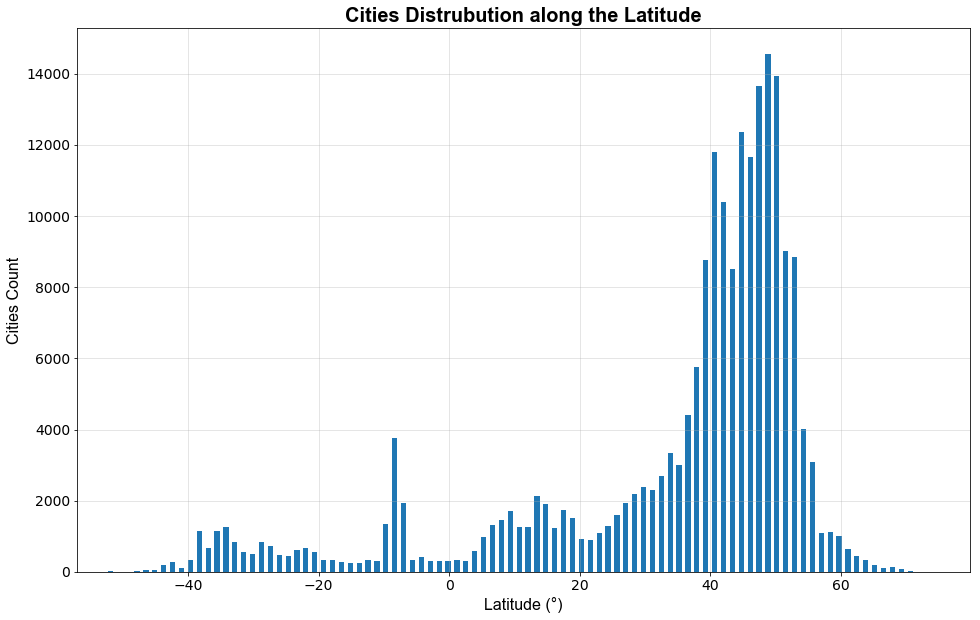

In [11]:
# Lets just take a peek at how cities are spread across the whole latitude range
cities_count = [len(city_group) for city_group in city_groups]
plt.figure(figsize=fig_size)
plt.bar(latitude_bins, cities_count)
plt.xlabel('Latitude (°)', **axis_font)
plt.xlim(min_latitude - 1, max_latitude + 1)
#plt.ylim(21, 99)
plt.xticks(fontsize=ticks_fontsize)
plt.ylabel('Cities Count', **axis_font)
plt.yticks(fontsize=ticks_fontsize)
plt.title(f'Cities Distrubution along the Latitude', **title_font)
plt.grid(alpha=0.4)
plt.savefig('../Output/Charts/CitiesDistrubution.png')
plt.show()

In [18]:
# For every latitude subrange pick X random cities that fall into it (up to X if the total number of cities
# in this subrange is less than X)  
# Initially set the weather data to empty values
temperature = np.full(len(city_groups),np.NaN,dtype=float)
humidity = np.full(len(city_groups),np.NaN,dtype=int)
cloudiness = np.full(len(city_groups),np.NaN,dtype=int)
wind_speed = np.full(len(city_groups),np.NaN,dtype=float)

total_cities_count = 0
call_count = 0
start_time = time.monotonic()

for i, city_group in enumerate(city_groups):
    city_count_to_pick = min(len(city_group), cities_per_bundle)
    if city_count_to_pick == 0:
        print(f'{i + 1:0>3}: skipping latitude interval ({latitude_bins[i - 1]:.6f},{latitude_bins[i]:.6f}) as there are no cities at all')
        continue
    picked_cities = np.random.choice(city_group, city_count_to_pick, False)
    city_group_name = "\n".join(''.rjust(5) + city['full_name'] for city in picked_cities)
    print(f'{i + 1:0>3}: Retrieving weather for the following cities:')    
    print(city_group_name)
    city_ids = [city['id'] for city in picked_cities]
    try:
        # Since we are limited to 60 API calls per minute we check if our next call is going to break this limit
        if call_count == api_call_limit:
            call_time = time.monotonic() - start_time
            # If it is, then we wait for the remaining time + 1 second
            if call_time < api_time_limit:
                print(''.rjust(5), 'Waiting a bit for not to exceed the API call rate limit')
                time.sleep(api_time_limit - call_time + 1)
            # then we are free to make calls again
            start_time = time.monotonic()
            call_count = 0
        weather_data = owm.get_current_for_group(city_ids, **settings)
        call_count += 1
    except HTTPError as err:
        error_message = json.loads(err.read())['message']
        print(f'{"".rjust(5)}ERROR!{error_message}')
        continue
        
    total_cities_count += city_count_to_pick
    temperature_list = [data('main.temp') for data in weather_data]
    humidity_list = [data('main.humidity') for data in weather_data]
    cloudiness_list = [data('clouds.all') for data in weather_data]
    wind_speed_list = [data('wind.speed') for data in weather_data]
    
    temperature[i] = np.median(temperature_list)
    humidity[i] = np.median(humidity_list)
    cloudiness[i] = np.median(cloudiness_list)
    wind_speed[i] = np.median(wind_speed_list)

001: Retrieving weather for the following cities:
     Ushuaia,AR
     Puerto Williams,CL
     South Georgia and the South Sandwich Islands,GS
     Barrio Almirante Brown,AR
002: Retrieving weather for the following cities:
     Provincia de Tierra del Fuego, Antártida e Islas del Atlántico Sur,AR
     Kaiken,AR
     Grytviken,GS
     Río Grande,AR
     Porvenir,CL
003: Retrieving weather for the following cities:
     Chabunco,CL
     Región de Magallanes y de la Antártica Chilena,CL
     Río de los Ciervos,CL
     Punta Arenas,CL
004: Retrieving weather for the following cities:
     Falkland Islands (Islas Malvinas),FK
     Puerto Bories,CL
     Yacimiento Rio Turbio,AR
     Rio Gallegos,AR
     Hill Station,AR
     Veintiocho de Noviembre,AR
     Puerto Natales,CL
     Stanley,FK
     Rincon Grande Settlement,FK
     Mare Harbour Rancho,FK
005: Retrieving weather for the following cities:
     San Julian,AR
     Puerto Santa Cruz,AR
     El Calafate,AR
     Comandante Luis Piedra B

024: Retrieving weather for the following cities:
     Vila Matias,BR
     Blackall,AU
     Carlópolis,BR
     Cajamar,BR
     Bertioga,BR
     Estiva,BR
     Mogoditshane,BW
     Salto de Pirapora,BR
     Congonhinhas,BR
     Antofagasta,CL
     Región de Antofagasta,CL
     San Pedro,AR
     Itanhaem,BR
     Candido de Abreu,BR
     Beecher,AU
     Sete Barras,BR
     Régulo Cassiano,MZ
     Bokaa,BW
     Natividade da Serra,BR
     Yuto,AR
025: Retrieving weather for the following cities:
     Bela Vista,BR
     Heliodora,BR
     Lucianópolis,BR
     Quintana,BR
     Rehoboth,NA
     Botucatu,BR
     Campo Alegre,BR
     Coorooman,AU
     Winton,AU
     Santo Antonio da Platina,BR
     Retro,AU
     Santo Antônio do Jardim,BR
     Imbetiba,BR
     Santa Rita de Caldas,BR
     Anhembi,BR
     Rio Preto,BR
     Assis,BR
     Senador José Bento,BR
     São João do Caiuá,BR
     Santa Maria da Serra,BR
026: Retrieving weather for the following cities:
     Ouéna,NC
     East Pilbara,AU


044: Retrieving weather for the following cities:
     Fuente de Oro,CO
     Saint-Georges-de-lOyapock,GF
     Departamento del Meta,CO
     Buta,CD
     Polonia,ID
     Bintulu,MY
     Buenaventura,CO
     Dagua,CO
     Pader,UG
     Yokadouma,CM
     Isiro,CD
     Castilla La Nueva,CO
     Perbaungan,ID
     Maracha,UG
     Mentekab,MY
     Bondo,CD
     Ataco,CO
     Guachené,CO
     Seremban,MY
     Neiva,CO
045: Retrieving weather for the following cities:
     Tenjo,CO
     Marsella,CO
     La Calera,CO
     Supata,CO
     Luuk Datan,PH
     Villa Hermosa,CO
     Paratebueno,CO
     Sabaneta,CO
     Bapaidu,CD
     New Bell,CM
     Somondoco,CO
     Obando,CO
     La Vega,CO
     Calarca,CO
     Parit Buntar,MY
     Cucunuba,CO
     Magwi County,SS
     La Victoria,CO
     Bongao,PH
     Une,CO
046: Retrieving weather for the following cities:
     La Estrella,CO
     Fort Wellington,GY
     Yala,TH
     Pore,CO
     Ranau,MY
     Bagado,CO
     Labranzagrande,CO
     Djo,CM
    

064: Retrieving weather for the following cities:
     Ansley,US
     Yantianhe,CN
     Songxia,CN
     Hujra,PK
     Xintian,CN
     Miaoshou,CN
     Macville (historical),US
     Jefferson Davis Parish,US
     Yuanjiaqiao,CN
     Zhongtai,CN
     Banqiaotou,CN
     Nahiyat Atbah,IQ
     Amloh,IN
     Wupu,CN
     Tamanar,MA
     Inezgane,MA
     Carrabelle,US
     Daishan,CN
     Pinewood Estates,US
     Orange Beach,US
065: Retrieving weather for the following cities:
     Chengjia,CN
     Center,US
     Raymond,US
     Howell (historical),US
     Khallat Salih,PS
     Santa Teresa,US
     Xiangshan,CN
     Colfax,US
     Ayn Janna,JO
     Oulad el Haj,MA
     Longfeng,CN
     Alvarado,US
     Richwood,US
     Wuxi,CN
     Xiting,CN
     Marshallville,US
     Yushan,CN
     Andrews,US
     Khallat ad Dar,PS
     Idhna,PS
066: Retrieving weather for the following cities:
     Kasuga,JP
     Boujniba,MA
     Khvansar,IR
     Ostān-e Īlām,IR
     Alabaster,US
     Aliceville,US
     Da

084: Retrieving weather for the following cities:
     Novopistsovo,RU
     Lukino,RU
     Mersrags,LV
     Ellon,GB
     Vangazi,LV
     Östra Vi,SE
     Kuznechikha,RU
     Baksheyevo,RU
     Highland,GB
     Alingsås Kommun,SE
     Henan,SE
     Vargarda,SE
     Billdal,SE
     Lejasciems,LV
     Tain,GB
     Iska-Chebakova,RU
     Adazi,LV
     Dulyapino,RU
     Verkhnechusovskiye Gorodki,RU
     Balvu Rajons,LV
085: Retrieving weather for the following cities:
     Sindi,EE
     Paikuse,EE
     Yelkino,RU
     Mariestad,SE
     Hjelmeland,NO
     Degerfors,SE
     Lyubytino,RU
     Pechenga,RU
     Yermolitsa,RU
     Türi vald,EE
     Dease Lake,CA
     Kimstad,SE
     Lidingoe,SE
     New Stuyahok,US
     Barkaker,NO
     Saeffle,SE
     Sem,NO
     Kiili vald,EE
     Valle,NO
     Sandnes,NO
086: Retrieving weather for the following cities:
     Sozimskiy,RU
     Krutoy Pochinok,RU
     Lemland,AX
     Gostilitsy,RU
     Sosnovyy Bor,RU
     Fjerdingby,NO
     Voznesenye,RU
    

In [19]:
# Creating a dataframe with all the data
weather_data = pd.DataFrame({
    'Latitude': latitude_bins,
    'Temperature': temperature,
    'Humidity': humidity,
    'Cloudiness': cloudiness,
    'Wind Speed': wind_speed
}).dropna(how='any')
print(f'We have {len(weather_data.index)} data points across the latitude range of {latitude_range:.6f}° which accumulate measurements from {total_cities_count} cities')
weather_data.head()

We have 99 data points across the latitude range of 134.785301° which accumulate measurements from 1800 cities


,Latitude,Temperature,Humidity,Cloudiness,Wind Speed
0,-56.000000,39.200,64,20,8.05
1,-54.638532,29.750,93,88,8.05
2,-53.277065,41.000,93,90,10.29
3,-51.915597,33.800,100,89,5.82
4,-50.554129,37.895,94,62,5.28
